Similarity matrix s(i,k), reflects how suitable data point k is to serve as an exemplar for data point i.
Responsibilty matirx a(i,k), indicates the accumulated evidence for choosing k as the exemplar of point i, taking into account other candidate exemplars. It is a message sent from i to k.
Availabilty matirx a(i,k), indicates the accumulated evidence of how appropriate is for point i to pick k as its exemplar, given the support from other points that k is an exemplar

for any data point i, the point k that maximizes r(i,k)+a(i,k) either represents that point k is an exemplar if k=i or point k is the exemplar of point i

https://github.com/GGiecold/Concurrent_AP/blob/master/Concurrent_AP.py
https://github.com/ritchie46/vanilla-machine-learning/blob/master/clustering/affinity_propagation.ipynb
https://www.ritchievink.com/blog/2018/05/18/algorithm-breakdown-affinity-propagation/
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#affinity-propagation

In [1]:
from abc import ABCMeta, abstractmethod
from contextlib import closing
from ctypes import c_double, c_int

In [2]:
import gc
import multiprocessing

In [3]:
import optparse
import psutil
import time
import warnings

In [4]:
# all the imports needed for this blog
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
import imageio
from io import BytesIO
%matplotlib inline
import numba
from numba import jit

In [5]:
import sklearn.cluster as cluster
import seaborn as sns
from sklearn import datasets

sns.set_context('poster')
sns.set_color_codes()

In [6]:
# just to check the memory situation on machine 
def memory():
    """Determine memory specifications of the machine.
    Returns
    -------
    mem_info : dictonary
        Holds the current values for the total, free and used memory of the system.
    """

    mem_info = dict()

    for k, v in psutil.virtual_memory()._asdict().items():
           mem_info[k] = int(v)
           
    return mem_info
mem_free = memory()
mem_free

{'active': 51539275776,
 'available': 3910709248,
 'buffers': 567152640,
 'cached': 3146158080,
 'free': 1711546368,
 'inactive': 703619072,
 'percent': 93,
 'shared': 991354880,
 'slab': 3845029888,
 'total': 59087470592,
 'used': 53662613504}

## Data 

In [7]:
# functions for load or save a dictionary
import pickle
def save_obj(obj, obj_name):
    with open('.'+'/'+ obj_name+ '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
def load_obj(obj_name):
    with open('.'+'/'+ obj_name+'.pkl', 'rb') as f:
        return pickle.load(f)    

In [8]:
def make_fake_2d_data(N_data_E_category=[20,20,20,20,20],Scnd_d=2,Visualization=True):
    
    """ 
    a function for creating fake data to check the performance of the affinity propagation algorithm
    User can adjust the number of categories along with the number of data in each one \
    (to chaeck the performance of algorithm for imbalanced data)
    #Scnd_d=2  number of features of the data (for the purpose of visualization,the default is 2)
    """
    np.random.seed(3)
    for i,N in enumerate(N_data_E_category):        
        size = (N, Scnd_d)
        
        if i==0:
            Data_i = np.random.normal(0, 1, size)
            Data=Data_i
        else:
            center = np.random.rand(2) * 10
            Data_i=np.random.normal(center, .5, size)
            Data=np.r_[Data,Data_i]
    
    
    N_category=len(N_data_E_category)  
    if (N_category<8 and Scnd_d==2 and Visualization==True):
        
        color_list=list('bgrcmyk')[:N_category]
        c = [c for s in [v * N for v,N in zip(color_list,N_data_E_category)] for c in list(s)]
        plt.figure(figsize=(15, 6))
        plt.title('Some clusters in 2d space')
        plt.scatter(Data[:, 0], Data[:, 1], c=c)
        plt.show()
    return Data

#### Data Visulaization Functions

In [9]:
def plot_2d_data(Data_X):
    plt.figure(figsize=(15, 6))        
    plt.scatter(Data_X[:, 0], Data_X[:, 1])
    plt.show()
    
    

#### Selecting Dataset from the available ones

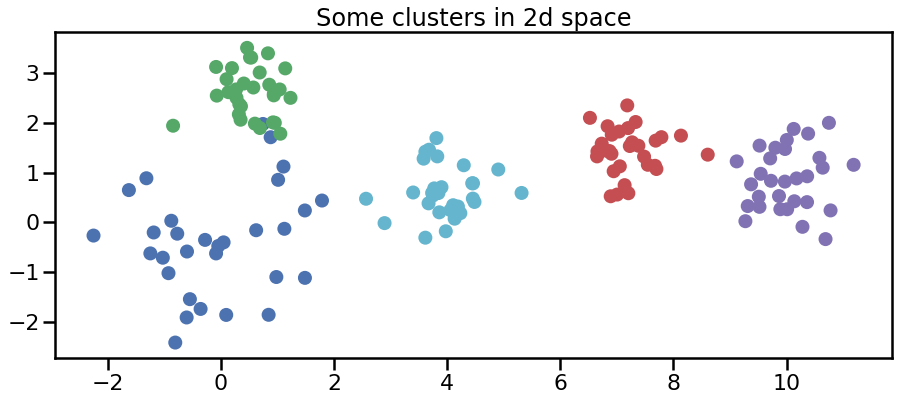

In [10]:
Interested_Dataset=['fake_data','iris_data','Environmental_data'][0]
if Interested_Dataset=='fake_data':
    N_data_E_category_balanced_imbalanced=[[30,30,30,30,30],[15,20,40,20,50]][0]
    Data_Input=make_fake_2d_data(N_data_E_category=N_data_E_category_balanced_imbalanced)
elif Interested_Dataset=='iris_data':    
    iris = datasets.load_iris()
    Data_Input = iris.data
    plot_2d_data(Data_Input)
elif Interested_Dataset=='Environmental_data':
     
    BCF_Elevation=np.load("BCF_Elevation.npy")
    Data_Input =BCF_Elevation[ np.random.choice(np.arange(BCF_Elevation.shape[0]),1000),:]
    plot_2d_data(Data_Input)
else:
    print("the Interested dataset is not available")



### Compute the clustering via Skit-Learn algorithms

In [262]:


plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

def Sklearn_clusters(data, algorithm, args, kwds, Plot_Clusters=True):
    """ a function for performing clustering with Skit-Learn library"""
    
    start_time = time.time()
    #######
    #labels = algorithm(*args, **kwds).fit_predict(data)
    model=algorithm(*args, **kwds).fit(data)
    labels=model.labels_
    if algorithm==cluster.AffinityPropagation:
        cluster_centers_indices=model.cluster_centers_indices_
        cluster_centers=model.cluster_centers_
    if algorithm==cluster.KMeans:
        cluster_centers=model.cluster_centers_
    ####
    end_time = time.time()
    
    if Plot_Clusters == True:
        plot_clusters(data,gapless_labels=labels)
   
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    print('Clustering took {:.2f} s'.format(end_time - start_time))
    if algorithm==cluster.AffinityPropagation:
        return labels,cluster_centers_indices,cluster_centers
    if algorithm==cluster.KMeans:
        return labels,cluster_centers
    else:
        return labels
    

    #plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    

### functions 

In [12]:
cache_=False
nopython_=True

In [13]:
%load_ext cython

In [14]:
def Similarity(x,y):
    """computes the similarity, negative eulidian distance, between two vecotrs"""
    return -np.sum((x-y)**2)


In [498]:

#@jit(nopython=nopython_, cache=cache_)
def Initialize_Matrices(X_data,Similarity_metric='Euclidean',memory_efficinet=True,*args):
    """create the similarity (S), availability (A) and Responsibility (R) matrices given input data
    X_data >> rows represent observations and columns represent features 
    
    We accommodate one standard metric (Euclidean) as well as one nonstandard metric (sentence similarity). 
    
    *args: dictionary=dictionary sets the dictionary to use in the sentence similarity case
    """

    n=X_data.shape[0]
    S=np.zeros((n,n))
    A=np.zeros((n,n))
    R=np.zeros((n,n))
    if Similarity_metric=='Euclidean':
        if memory_efficinet==False:
            for i in range(n-1):
                for j in range(i+1,n):
                        S[i,j]=Similarity(X_data[i,:],X_data[j,:]) 
            S=S+S.T
            
        else:
            S=-1*pairwise_dists(X_data, X_data)
        return S,R,A
    if Similarity_metric =='Sentences':
        if memory_efficinet==False:
            for i in range(n):
                for j in range(n):
                    # here, X_data would be an array of sentences
                    S[i,j] = sentence_similarity(X_data[i], X_data[j], dictionary)
        else:
            # S = sentence_similarity_efficient(X_data)
            raise ValueError("Haven't coded an efficient version for sentence similarity yet.")
        return S,R,A
                    
    else:
        raise ValueError("The only Predefined Similarity metrics are 'Euclidean' or 'Sentences'.\
 For '%s' metric, a new function should be defined"%Similarity_metric)

In [16]:
#@jit(nopython=nopython_, cache=cache_)
def pairwise_dists(x, y):
    """ Computing pairwise distances using memory-efficient
        vectorization.

        Parameters
        ----------
        x : numpy.ndarray, shape=(M, D)
        y : numpy.ndarray, shape=(N, D)

        Returns
        -------
        numpy.ndarray, shape=(M, N)
            The square Euclidean distance between each pair of
            rows between `x` and `y`."""
    return  np.sum(x**2,axis=-1).reshape(-1,1)+np.sum(y**2,axis=-1)-2*np.dot(x,y.T) 

In [17]:
def Update_R_loop(S,R,A,damping_factor=0.5):
    n=S.shape[0]
    for i in range(n):
        for k in range(n):
            # approach 1
    #         Ids_kp=[kp for kp in list(range(n)) if not kp==k and not kp==i]
    #         temp=np.max(A[i,Ids_kp]+S[i,Ids_kp])
            #approach 2
            temp1=(A[i,:]+S[i,:])
            temp1[i]=-np.inf
            temp1[k]=-np.inf
            temp=np.max(temp1)

            R[i,k]=R[i,k]*damping_factor+(S[i,k]-temp)*(1-damping_factor)
    return R

In [18]:
#@jit(nopython=nopython_, cache=cache_)
def Update_R_Broadcast(S,R,A,temp=None,damping_factor=0.5):
    if temp is None: temp=np.zeros_like(R)
    temp=A+S
    temp.flat[::(temp.shape[0]+1)]=-np.inf #np.fill_diagonal(temp,-np.inf) 
    rows=np.arange(S.shape[0])
    Id_max_E_row=np.argmax(temp,axis=1)
    first_max=temp[rows,Id_max_E_row]
    temp[rows,Id_max_E_row]=-np.inf
    second_max=temp[rows,np.argmax(temp,axis=1)]
    Max_mat_A_plus_S=np.zeros_like(S)+first_max.reshape(-1,1)#[:,None]
    Max_mat_A_plus_S[rows,Id_max_E_row]=second_max
    R=R*damping_factor+(S-Max_mat_A_plus_S)*(1-damping_factor)
    return R

In [19]:
def Update_A_loop(R,A,damping_factor=0.5):
    n=R.shape[0]
    for i in range(n):
        for k in range(n):
            
            temp1=np.array(R[:, k]) #R[:,k]+0.0 
            temp1[i]=-np.inf
            temp1[k]=-np.inf

            temp_sum=np.sum(temp1[temp1>0])
            
            if i!=k:
                A[i,k]=(damping_factor)*A[i,k]+(1-damping_factor)*min(0, R[k,k]+temp_sum)
            else:            
                A[i,k]=(damping_factor)*A[i,k]+(1-damping_factor)*temp_sum
    return A

In [20]:
#@jit(nopython=nopython_, cache=cache_)
def Update_A_Broadcast(R,A,temp=None,damping_factor=0.5):
    
    if temp is None: temp=np.zeros_like(R)
    Approach_paper=True
    if Approach_paper==False:
        a=np.array(R)
        a=np.where(a<0,0,a)# np.clip(a,0,np.inf) # a[a<0]=0 # np.maximum(R, 0, a)
        np.fill_diagonal(a,0)
        temp2=np.sum(a,axis=0)
        a=temp2-np.clip(R,0,np.inf) #np.sum(a,axis=0)-np.clip(a,0,np.inf)
        a=a+np.diag(R)
        a[a>0]=0 # np.clip(a,-np.inf,0)

        np.fill_diagonal(a,temp2)
    else:
        np.maximum(R, 0, temp)        
        temp.flat[::(temp.shape[0]+1)]=np.diag(R) #np.fill_diagonal(temp,np.diag(R)) #temp.flat[::(temp.shape[0]+1)]=np.diag(R)
        temp=np.sum(temp,axis=0)-temp
        temp2=np.diag(temp)
        temp[temp>0]=0 # np.clip(a,-np.inf,0)
        temp.flat[::(temp.shape[0]+1)]=temp2 #np.fill_diagonal(temp,temp2)#temp.flat[::(temp.shape[0]+1)]=temp2
        
    A=damping_factor*A+(1-damping_factor)*temp
    
    
    return A

In [21]:
# make sure that both approaches of updating R match

S,R,A=Initialize_Matrices(Data_Input)
R_loop=Update_R_loop(S,R,A)
S,R,A=Initialize_Matrices(Data_Input)
R_Broadcast=Update_R_Broadcast(S,R,A)

np.testing.assert_allclose(R_Broadcast,R_loop) #np.allclose(R_Broadcast,R_loop)

In [22]:
# check speed R update
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_R_loop(S,R,A)
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_R_Broadcast(S,R,A)

249 ms ± 19.8 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
348 µs ± 54.6 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)


In [23]:
# make sure that both approaches of updating A match
S,R,A=Initialize_Matrices(Data_Input)
A_b=Update_A_Broadcast(R,A)
S,R,A=Initialize_Matrices(Data_Input)
A=Update_A_loop(R,A)
np.testing.assert_allclose(A,A_b)# np.allclose(A,A_b)

In [24]:
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_A_Broadcast(R,A)
S,R,A=Initialize_Matrices(Data_Input)
%timeit -r3 -n3 Update_A_loop(R,A)

211 µs ± 18 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
328 ms ± 22.5 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


### Cluster Visualization function



In [43]:
def plot_clusters(data,gapless_labels):
    fig = plt.figure(figsize=(15, 5))
    palette = sns.color_palette(palette='deep', n_colors=np.unique(gapless_labels).max() + 1)
    colors = [palette[x] for x in gapless_labels] #[palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.show()

In [26]:
def plot_iteration(iter_i,labels,exemplars,Data,Draw_lines=False):
    """ Here we assume that we are working with 2d data for the purpose of visualization"""
    fig = plt.figure(figsize=(15, 5))
    
    colors = dict(zip(exemplars, cycle('bgrcmyk')))
    
    for i in range(len(labels)):
        X = Data[i][0]
        Y = Data[i][1]
        
        if i in exemplars:
            exemplar = i
            edge = 'k'
            ms = 10
        else:
            exemplar = labels[i]
            ms = 3
            edge = None
            if Draw_lines==True:
                plt.plot([X, Data[exemplar][0]], [Y, Data[exemplar][1]], c=colors[exemplar])
            else:
                plt.plot([Data[exemplar][0]], [Data[exemplar][1]], c=colors[exemplar])
        plt.plot(X, Y, 'o', markersize=ms,  markeredgecolor=edge, c=colors[exemplar])
        

    plt.title('Number of exemplars: %d @ iteration: %d' % (len(exemplars),iter_i))
    return fig

### main function

In [497]:
def affinity_propagation(Data_X_samples, Similarity_metric_='Euclidean',preference=None, max_iter=200,max_err=1e-4,
                         damping=0.5, copy=True, verbose=False,
                         return_n_iter=False,Visulization_track=False,Plot_Clusters=True,Draw_lines=False):
    """
    
    """
    
    if Similarity_metric_=='Euclidean':
        Data_X=np.copy(Data_X_samples)
        n_samples=Data_X.shape[0]
        S,R,A=Initialize_Matrices(Data_X,Similarity_metric_)
    elif Similarity_metric_=='Sentences':
        Data_X = np.array(Data_X_samples)
        n_samples=len(Data_X)
        S,R,A=Initialize_Matrices(Data_X,Similarity_metric_,memory_efficinet=False)
    

    if preference is None:
        preference = np.median(S)
    if damping < 0.5 or damping >= 1:
        raise ValueError('Based on the suggestion of authors (Brendan J. Frey* and Delbert Dueck 2007) ,\
        damping must be >= 0.5 and < 1')

    preference = np.array(preference)
    S.flat[::(n_samples + 1)] = preference #np.fill_diagonal(S,preference)  #  S.flat[::(n_samples + 1)] = preference
    
    # Intermediate results
    current_sol=np.zeros_like(S)
    temp_arr=np.zeros_like(S)
    
    
    last_sol=np.zeros_like(S)
    current_sol=np.zeros_like(S)
    last_exemplars = np.array([])
    
    # Remove degeneracies
    random_state = np.random.RandomState(0)
    S += ((np.finfo(np.double).eps * S + np.finfo(np.double).tiny * 100) *
          random_state.randn(n_samples, n_samples))
    
    figures=[]
        
    for it in range(max_iter):

        R=Update_R_Broadcast(S,R,A,temp_arr,damping)
        A=Update_A_Broadcast(R,A,temp_arr,damping)
        
        current_sol=A+R
        labels = np.argmax(current_sol, axis=1)
        exemplars = np.unique(labels)
        
        if Visulization_track==True:
            if (np.all(last_exemplars != exemplars)):
                figures.append(plot_iteration(it,labels,exemplars,Data_X,Draw_lines=Draw_lines))
        
        if np.allclose(last_sol, current_sol):#np.sqrt(np.sum((last_sol- current_sol)**2)) < max_err:# np.allclose(last_sol, current_sol):
            print(exemplars, it)
            break

        last_sol = current_sol
        last_exemplars = exemplars
    # mapping the labels into a sorted, gapless, list    
    #labels = np.searchsorted(last_exemplars, labels)
    
    Cluster_Centers=Data_X[last_exemplars]
    
    if Plot_Clusters==True:
        plot_clusters(Data_X,gapless_labels=np.searchsorted(last_exemplars, labels))
        #plot_iteration(it,labels,last_exemplars,Data_X,Draw_lines)
    
    if Visulization_track==True:
        return last_exemplars,labels,Cluster_Centers,it,figures
    else:
        return last_exemplars,labels,Cluster_Centers,it
    

In [28]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Data_Input,max_iter=200,Plot_Clusters=False)

[  3  25  51  62 107 138] 69
CPU times: user 148 ms, sys: 196 ms, total: 344 ms
Wall time: 77.1 ms


[  3  25  51  62 107 138] 69


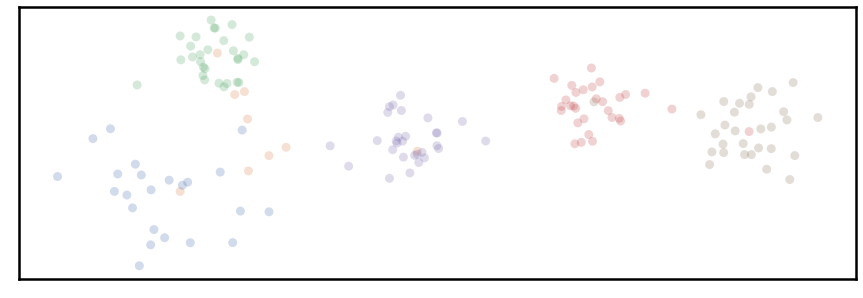

CPU times: user 248 ms, sys: 368 ms, total: 616 ms
Wall time: 175 ms


In [29]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Data_Input,max_iter=200,Plot_Clusters=True)

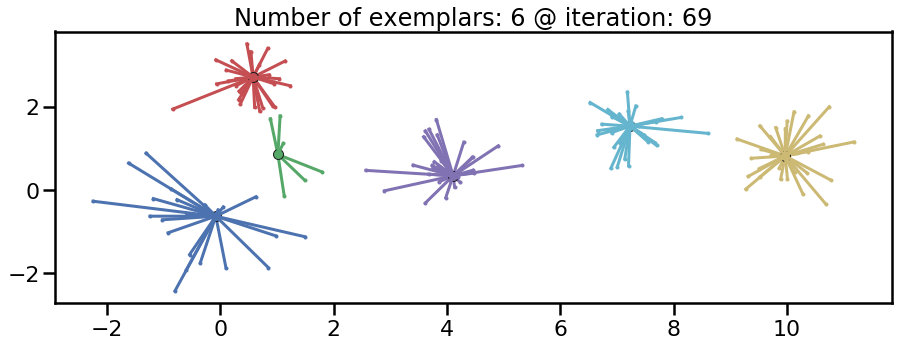

In [30]:
fig= plot_iteration(last_iteration,labels,exemplars,Data_Input,Draw_lines=True)

### Compareing with Skit-Learn

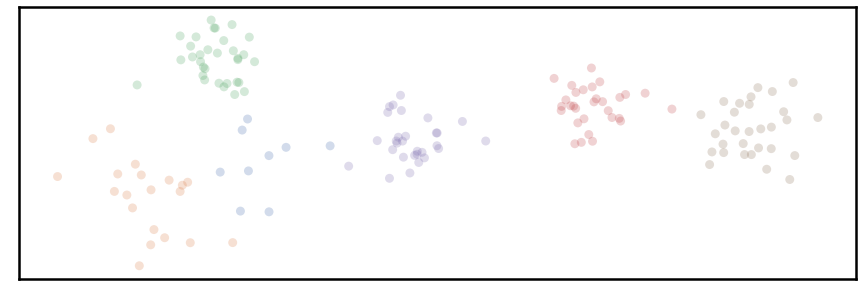

Clustering took 0.06 s
CPU times: user 256 ms, sys: 316 ms, total: 572 ms
Wall time: 163 ms


In [65]:
%%time
args=()
kwds={'damping':0.5,'convergence_iter':100}
labels_SK,cluster_centers_indices_SK,cluster_centers_SK=Sklearn_clusters(Data_Input, cluster.AffinityPropagation, args, kwds)
labels_SK

In [66]:
print("Exemplars found by SKlearn: \n",np.unique(cluster_centers_indices_SK))
print("Exemplars found by Implemented Algorithm: \n",np.unique(labels))

Exemplars found by SKlearn: 
 [ 11  22  51  62  99 138]
Exemplars found by Implemented Algorithm: 
 [  3  25  51  62 107 138]


In [67]:
print("Cluster centers found by SKlearn: \n",cluster_centers_SK)
print("Cluster centers found by Implemented Algorithm: \n",Cluster_Centers)


Cluster centers found by SKlearn: 
 [[ 1.48614836  0.23671627]
 [-0.59664964 -0.58859438]
 [ 0.57541884  2.70899698]
 [ 7.22817703  1.53270549]
 [ 3.9002663   0.70472642]
 [ 9.96820508  0.81722836]]
Cluster centers found by Implemented Algorithm: 
 [[-0.08274148 -0.62700068]
 [ 1.01318344  0.85279784]
 [ 0.57541884  2.70899698]
 [ 7.22817703  1.53270549]
 [ 4.1061428   0.34226963]
 [ 9.96820508  0.81722836]]


In [68]:
from sklearn.metrics import pairwise_distances_argmin
def predict_cluster(Data_points,Cluster_centers):
    """ assigning each data point to a cluster by finding the minimum distance between each point and cluster centers"""
    return pairwise_distances_argmin(Data_points,Cluster_centers)

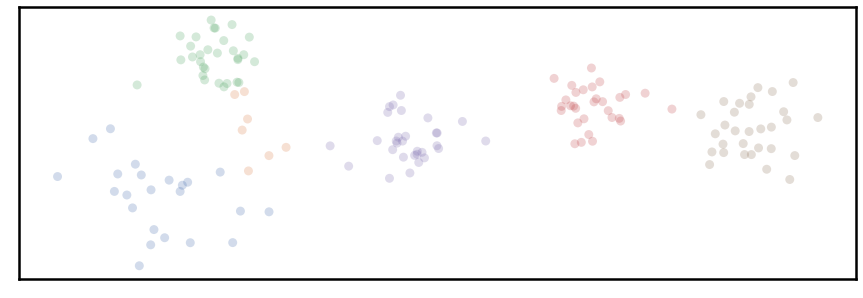

In [69]:
plot_clusters(Data_Input,gapless_labels=predict_cluster(Data_Input,Cluster_Centers) )

### some efforts for speeding up 

In [70]:
from multiprocessing import Pool, Value
from joblib import Parallel
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing as mp

[  3  25  51  62 107 138] 69


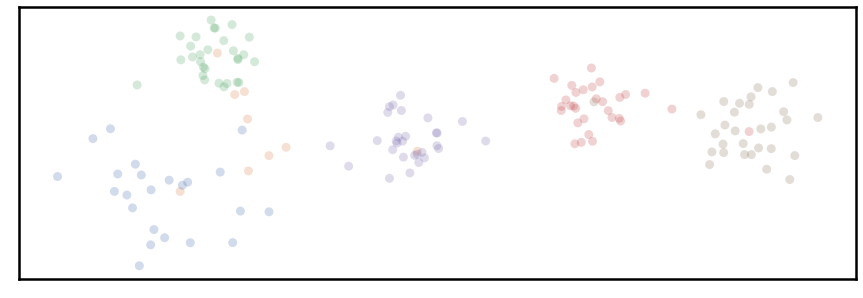

CPU times: user 232 ms, sys: 416 ms, total: 648 ms
Wall time: 224 ms


In [71]:
%%time

with ProcessPoolExecutor(max_workers=4) as pool:
    pool.submit(affinity_propagation(Data_Input))

[  3  25  51  62 107 138] 69


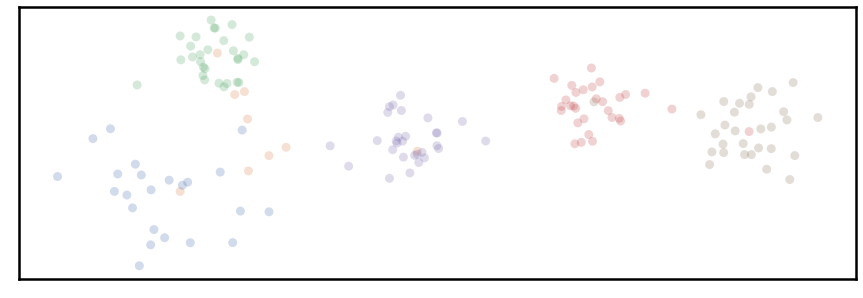

CPU times: user 264 ms, sys: 376 ms, total: 640 ms
Wall time: 312 ms


In [72]:
%%time

with ThreadPoolExecutor(max_workers=4) as pool:
    pool.submit(affinity_propagation(Data_Input))

[  3  25  51  62 107 138] 69


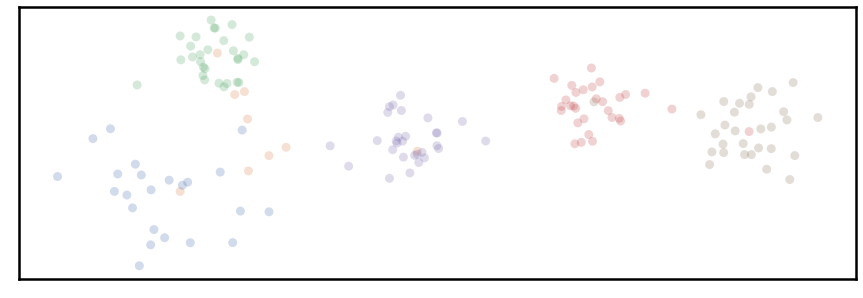

CPU times: user 244 ms, sys: 288 ms, total: 532 ms
Wall time: 337 ms


In [73]:
%%time
with Pool(processes=4) as pool:
    #pool.apply(affinity_propagation(Data_Input))
    pool.apply_async(affinity_propagation(Data_Input))

[  3  25  51  62 107 138] 69


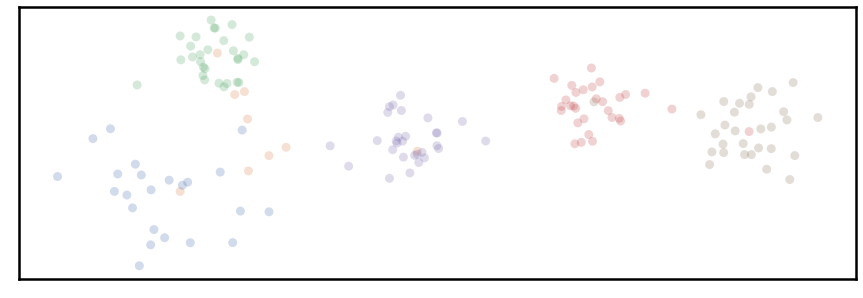

CPU times: user 264 ms, sys: 332 ms, total: 596 ms
Wall time: 181 ms


In [74]:
%%time
_=affinity_propagation(Data_Input)

In [75]:
%prun -q -D affinity_propagation.prof affinity_propagation(Data_Input,Plot_Clusters=False)

[  3  25  51  62 107 138] 69
 
*** Profile stats marshalled to file 'affinity_propagation.prof'. 


In [76]:
# n=200
# A=np.random.randn((n,n))
# b=np.random.randn(n)
# %timeit np.fill_diagonal(A,b)
# %timeit A[::n+1]=b

In [77]:
import pstats
p = pstats.Stats('affinity_propagation.prof')
p.sort_stats('time', 'cumulative').print_stats()
pass

Thu Apr 23 18:18:59 2020    affinity_propagation.prof

         10705 function calls (10058 primitive calls) in 0.126 seconds

   Ordered by: internal time, cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       70    0.026    0.000    0.032    0.000 <ipython-input-20-ac169a578390>:2(Update_A_Broadcast)
       70    0.019    0.000    0.031    0.000 /opt/conda/lib/python3.6/site-packages/numpy/core/numeric.py:2244(within_tol)
      285    0.014    0.000    0.014    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       70    0.013    0.000    0.024    0.000 <ipython-input-18-03834b81ab85>:2(Update_R_Broadcast)
       70    0.009    0.000    0.044    0.001 /opt/conda/lib/python3.6/site-packages/numpy/core/numeric.py:2167(isclose)
      210    0.008    0.000    0.008    0.000 {method 'argmax' of 'numpy.ndarray' objects}
      142    0.008    0.000    0.009    0.000 /opt/conda/lib/python3.6/site-packages/numpy/core/_ufunc_config.py:39(seterr)
 1283

In [78]:
ipyparallel_lib=False
if ipyparallel_lib==True:
    from ipyparallel import Client
    rc = Client()
    rc.ids
    %timeit rc[:].apply_async(affinity_propagation(Data_Input))

## Make a gif of Affinity Propagation Process

In [79]:
def make_gif(figures, filename, fps=10, **kwargs):
    images = []
    for fig in figures:
        output = BytesIO()
        fig.savefig(output)
        plt.close(fig)  
        output.seek(0)
        images.append(imageio.imread(output))
    imageio.mimsave(filename, images, fps=fps, **kwargs)

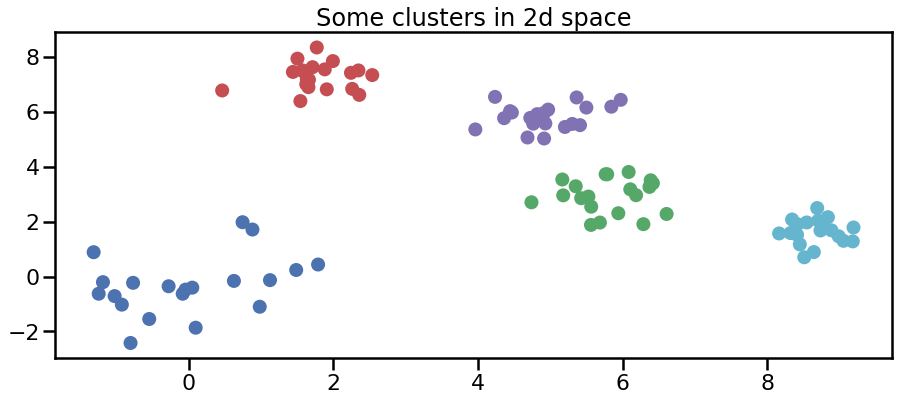

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


[ 7 11 31 53 61 93] 52


In [80]:
_,_,_,_,figures_AF=affinity_propagation(Data_X_samples=make_fake_2d_data(N_data_E_category=[20,20,20,20,20]),\
                                      Plot_Clusters=False,Visulization_track=True,Draw_lines=True)
make_gif(figures_AF, 'Affinity_Propagation.gif', 2)

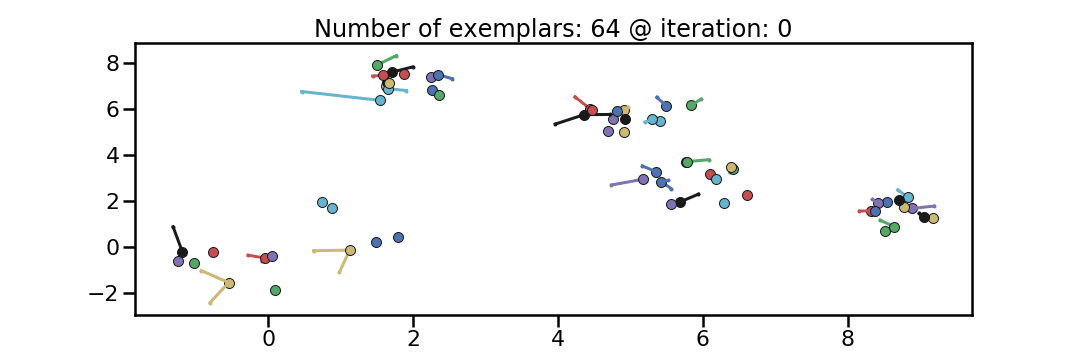

In [81]:
from IPython.display import Image
with open('Affinity_Propagation.gif','rb') as file:
    display(Image(file.read()))

In [82]:
""" Affinity Propagation Clustering of data
    
    Parameters
    ----------
    S : 
        array-like, shape (n_samples, n_samples)
        Matrix of similarities between points
        
    preference : 
        array-like, shape (n_samples,) or float, optional
        Preferences for each point - points with larger values of
        preferences are more likely to be chosen as exemplars. The number of
        exemplars, i.e. of clusters, is influenced by the input preferences
        value. If the preferences are not passed as arguments, they will be
        set to the median of the input similarities (resulting in a moderate
        number of clusters). For a smaller amount of clusters, this can be set
        to the minimum value of the similarities.
        
    max_iter : 
        int, optional, default: 200
        Maximum number of iterations
        
    damping :
        float, optional, default: 0.5
        Damping factor between 0.5 and 1.
        
    Returns
    -------
    cluster_centers_indices : 
        array, shape (n_clusters,)
        index of clusters centers
        
    labels : 
        array, shape (n_samples,)
        cluster labels for each point
        
    n_iter : 
        int
        number of iterations run. Returned only if `return_n_iter` is
        set to True.    
        
    Notes
    -----  
    When the algorithm does not converge, it returns an empty array as
    ``cluster_center_indices`` and ``-1`` as label for each training sample.
        
"""       

' Affinity Propagation Clustering of data\n    \n    Parameters\n    ----------\n    S : \n        array-like, shape (n_samples, n_samples)\n        Matrix of similarities between points\n        \n    preference : \n        array-like, shape (n_samples,) or float, optional\n        Preferences for each point - points with larger values of\n        preferences are more likely to be chosen as exemplars. The number of\n        exemplars, i.e. of clusters, is influenced by the input preferences\n        value. If the preferences are not passed as arguments, they will be\n        set to the median of the input similarities (resulting in a moderate\n        number of clusters). For a smaller amount of clusters, this can be set\n        to the minimum value of the similarities.\n        \n    max_iter : \n        int, optional, default: 200\n        Maximum number of iterations\n        \n    damping :\n        float, optional, default: 0.5\n        Damping factor between 0.5 and 1.\n       

## Comaprison with other clustering algorithm

#### K-Means

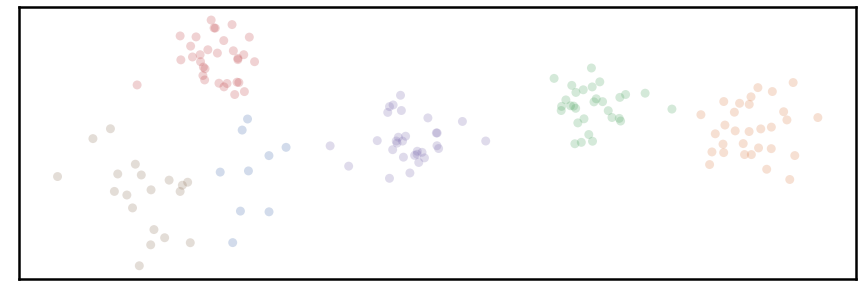

Clustering took 0.06 s


array([0, 5, 5, 5, 5, 5, 3, 5, 5, 0, 5, 0, 5, 0, 5, 3, 5, 5, 5, 0, 5, 5,
       5, 5, 5, 0, 0, 0, 0, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [83]:
labels_SK=Sklearn_clusters(Data_Input, cluster.KMeans, (), {'n_clusters':6})
#labels_SK=Sklearn_clusters(Data_Input, cluster.AffinityPropagation, args, kwds)
labels_SK

### Environmental data

In [84]:
Envirnonmental_Data_dic=load_obj('Envirnonmental_Data')
Envirnonmental_Data_dic

{'bcf': array([[ 1,  1,  0, ..., 98, 98, 97],
        [ 0,  1,  0, ..., 96, 98, 99],
        [ 1,  1,  0, ..., 96, 98, 99],
        ...,
        [ 3, 25, 26, ..., 48, 56, 55],
        [24,  9, 12, ..., 62, 60, 62],
        [32, 27, 27, ..., 70, 58, 59]], dtype=uint8),
 'dem': array([[1588.9183  , 1677.6432  , 1656.2432  , ..., 1611.0812  ,
         1609.4529  , 1607.8513  ],
        [1614.8094  , 1647.1166  , 1567.0974  , ..., 1607.8534  ,
         1606.7502  , 1605.412   ],
        [1571.3574  , 1543.9697  , 1545.6289  , ..., 1604.6162  ,
         1603.6112  , 1602.8593  ],
        ...,
        [ 112.668274,   94.585144,   83.91435 , ..., 2094.5278  ,
         1858.3633  , 1639.9668  ],
        [ 139.00487 ,  113.679   ,   91.71291 , ..., 1768.0704  ,
         1619.9907  , 1559.3394  ],
        [ 171.27051 ,  141.87949 ,  109.29649 , ..., 1536.9166  ,
         1409.3015  , 1334.4492  ]], dtype=float32),
 'lat': array([[37.995, 37.995, 37.995, ..., 37.995, 37.995, 37.995],
        [37.

In [85]:
#np.random.choice(np.arange(Envirnonmental_Data_dic['lat'].shape[0]),5000)
Envirnonmental_Data_dic['lat'].shape,Envirnonmental_Data_dic['dem'].shape

((200, 300), (200, 300))

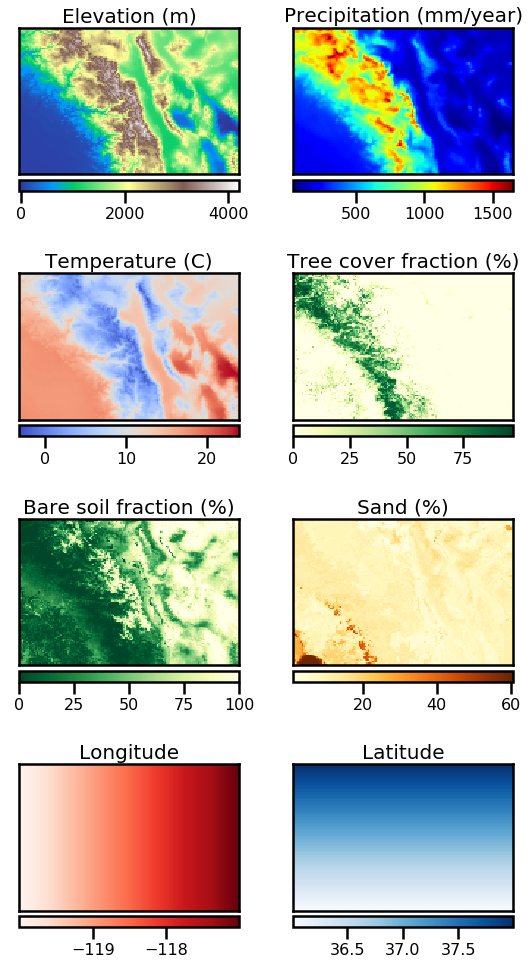

In [86]:
info = {'dem':{'cmap':'terrain','title':'Elevation (m)'},
        'ppt':{'cmap':'jet','title':'Precipitation (mm/year)'},
        'sand':{'cmap':'YlOrBr','title':'Sand (%)'},
        'tcf':{'cmap':'YlGn','title':'Tree cover fraction (%)'},
        'bcf':{'cmap':'YlGn_r','title':'Bare soil fraction (%)'},
        'tmean':{'cmap':'coolwarm','title':'Temperature (C)'},
        'lat':{'cmap':'Blues','title':'Latitude'},
        'lon':{'cmap':'Reds','title':'Longitude'}}
plt.figure(figsize=(8,14))
i = 0
for var in Envirnonmental_Data_dic:
    i += 1
    #print(i)
    plt.subplot(4,2,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Envirnonmental_Data_dic[var][::2,::2],cmap=plt.get_cmap(info[var]['cmap']))
    cb = plt.colorbar(orientation='horizontal',pad=0.03)
    cb.ax.tick_params(labelsize=16)
    plt.title(info[var]['title'],fontsize=20)
plt.tight_layout()
plt.show()

### Focus: Bare cover fraction vs Elevation

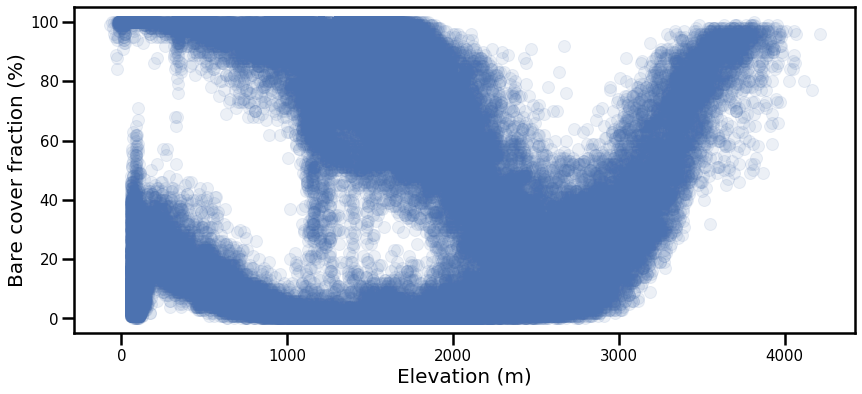

In [87]:
plt.figure(figsize=(14,6))
plt.plot(Envirnonmental_Data_dic['dem'],Envirnonmental_Data_dic['bcf'],'bo',alpha=0.1)
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Bare cover fraction (%)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()        

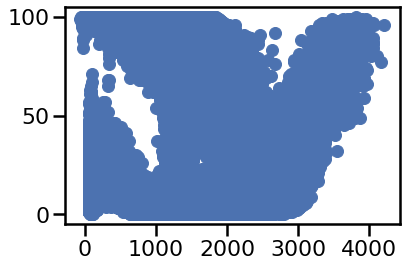

In [88]:
plt.plot(Envirnonmental_Data_dic['dem'],Envirnonmental_Data_dic['bcf'], 'bo')

## fit and prediction using K-Means

In [165]:
Xns.shape

(1000, 2)

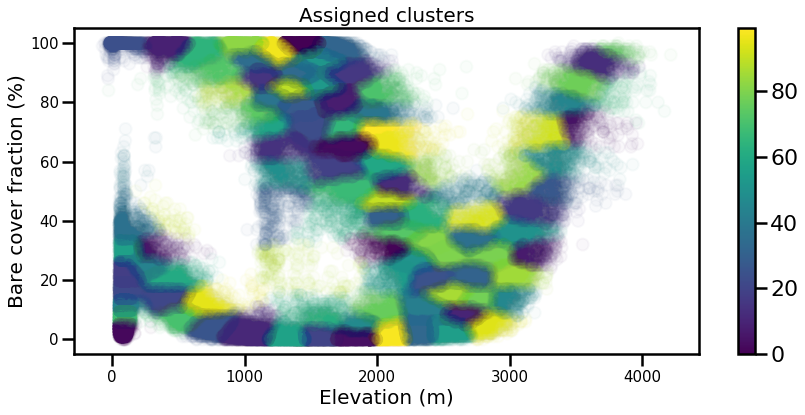

In [89]:
#Bring in the data
v1 = Envirnonmental_Data_dic['dem'].reshape(Envirnonmental_Data_dic['dem'].size)
v2 = Envirnonmental_Data_dic['bcf'].reshape(Envirnonmental_Data_dic['bcf'].size)
#Create data for scikit-learn
X = np.stack((v1,v2)).T
#Normalize the data
Xn = (X - np.min(X,axis=0))/(np.max(X,axis=0)-np.min(X,axis=0))
#Define the number of clusters
k = 100
np.random.seed(1)
model = cluster.KMeans(n_clusters=k)
#Subsample data to fit the model (minimize computation)

# We just use a small number of our data to fit the cluster
N_Data_fit=1000
idx = np.random.choice(np.arange(Xn.shape[0]),N_Data_fit)

Xns = Xn[idx,:]
#Fit the model
model.fit(Xns)
#Predict the clusters on all the data
clusters = model.predict(Xn)
plt.figure(figsize=(14,6))
plt.title('Assigned clusters',fontsize=20)
plt.scatter(Envirnonmental_Data_dic['dem'].reshape(Envirnonmental_Data_dic['dem'].size),Envirnonmental_Data_dic['bcf'].reshape(Envirnonmental_Data_dic['bcf'].size),
            c=clusters,cmap=plt.get_cmap('viridis'),alpha=0.03)
cb = plt.colorbar()
#Ensure the alpha of the colorbar is 1.0
cb.set_alpha(1.0)
cb.draw_all()
plt.xlabel('Elevation (m)',fontsize=20)
plt.ylabel('Bare cover fraction (%)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

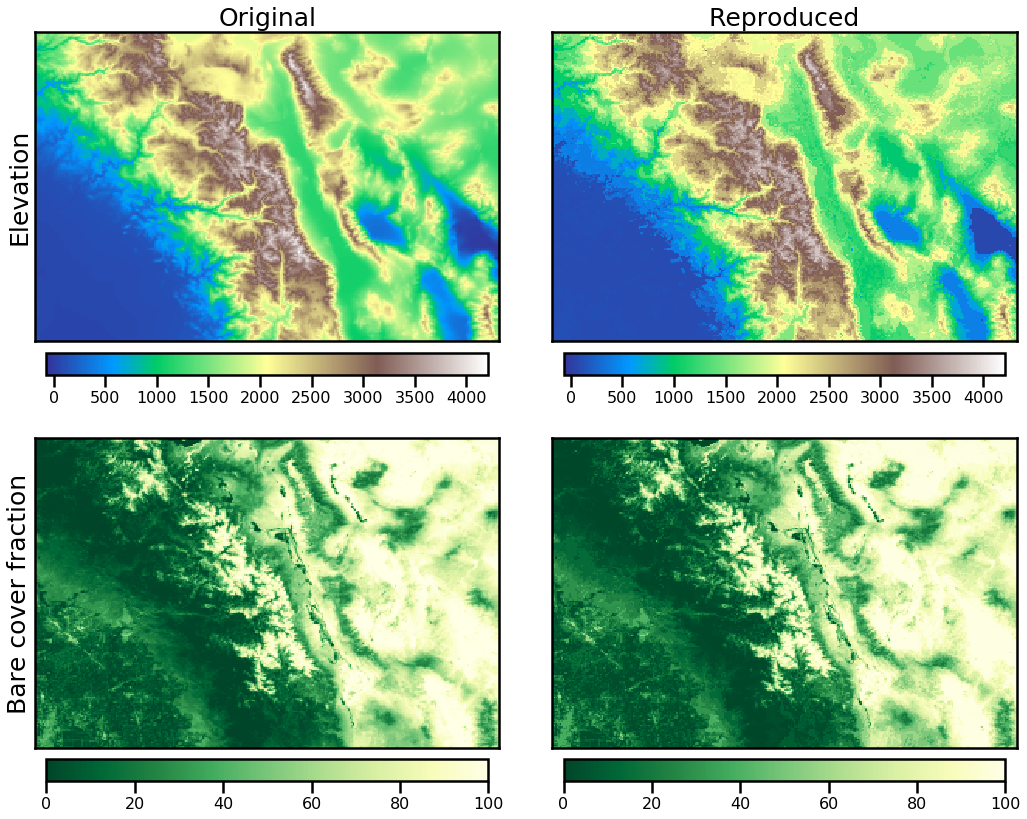

In [90]:
#Assign the cluster centroid values to each cluster
Xpred = np.copy(X)
for i in range(k):
    m = clusters == i
    Xpred[m,:] = np.mean(X[m,:],axis=0)
dem_pred = Xpred[:,0].reshape(Envirnonmental_Data_dic['dem'].shape)
bcf_pred = Xpred[:,1].reshape(Envirnonmental_Data_dic['bcf'].shape)
#Create a figure comparing them
vmin = np.min(Envirnonmental_Data_dic['dem'])
vmax = np.max(Envirnonmental_Data_dic['dem'])
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.imshow(Envirnonmental_Data_dic['dem'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.ylabel('Elevation',fontsize=25)
plt.title('Original',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(222)
plt.title('Reproduced',fontsize=25)
plt.imshow(dem_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
vmin = np.min(Envirnonmental_Data_dic['bcf'])
vmax = np.max(Envirnonmental_Data_dic['bcf'])
plt.subplot(223)
plt.imshow(Envirnonmental_Data_dic['bcf'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('YlGn_r'))
plt.ylabel('Bare cover fraction',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(224)
plt.imshow(bcf_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('YlGn_r'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

## fit and prediction using developed Affinity Propagation

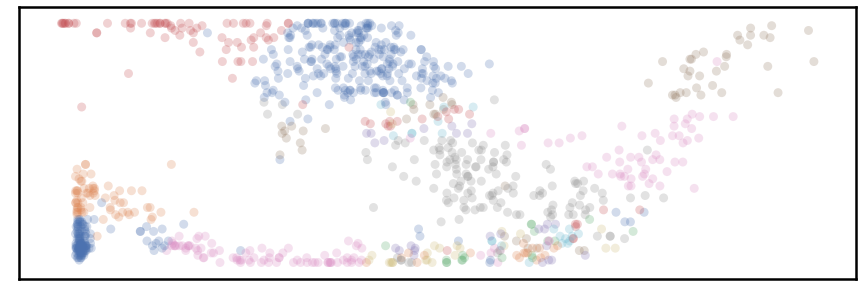

CPU times: user 7.48 s, sys: 496 ms, total: 7.97 s
Wall time: 7.51 s


In [91]:
%%time
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(Xns,preference=-1,max_iter=200,Plot_Clusters=True)

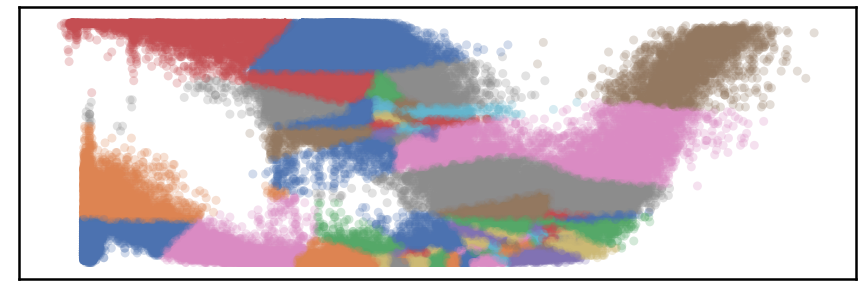

In [92]:
Predicted_labels=predict_cluster(Xn,Cluster_Centers)
plot_clusters(Xn,gapless_labels=Predicted_labels )

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


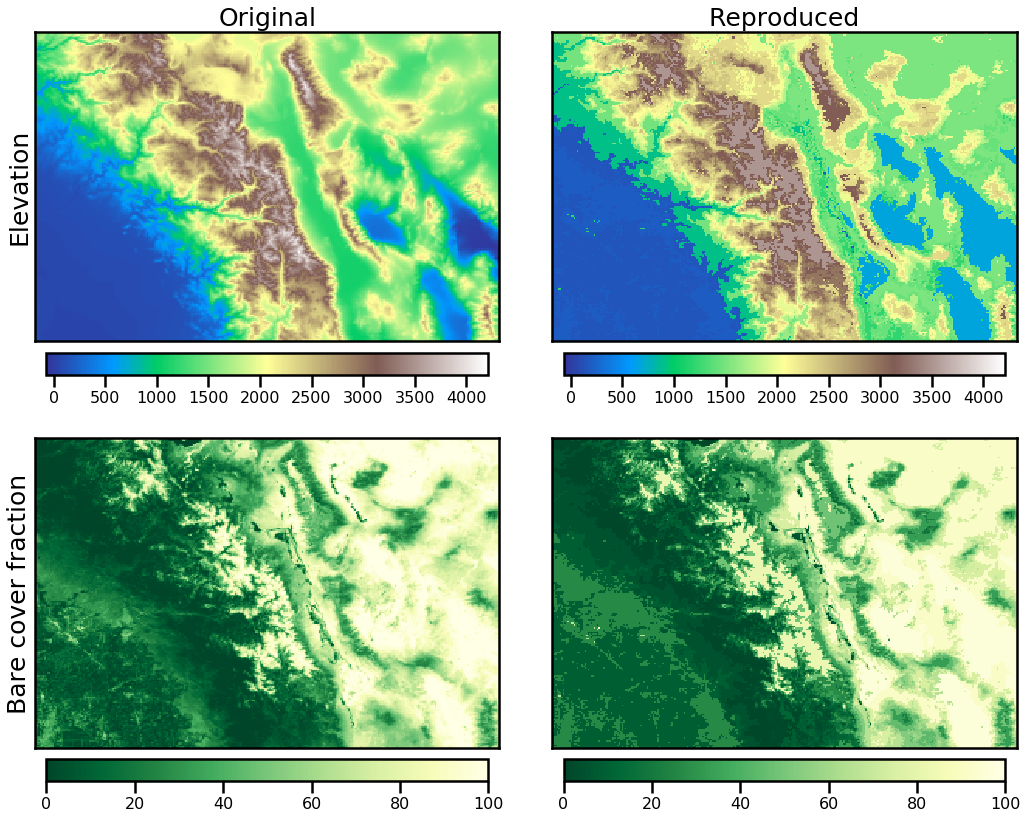

In [93]:
#Assign the cluster centroid values to each cluster
Xpred = np.copy(X)
for i in range(k):
    m =  Predicted_labels == i
    Xpred[m,:] = np.mean(X[m,:],axis=0)
dem_pred = Xpred[:,0].reshape(Envirnonmental_Data_dic['dem'].shape)
bcf_pred = Xpred[:,1].reshape(Envirnonmental_Data_dic['bcf'].shape)
#Create a figure comparing them
vmin = np.min(Envirnonmental_Data_dic['dem'])
vmax = np.max(Envirnonmental_Data_dic['dem'])
plt.figure(figsize=(15,12))
plt.subplot(221)
plt.imshow(Envirnonmental_Data_dic['dem'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.ylabel('Elevation',fontsize=25)
plt.title('Original',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(222)
plt.title('Reproduced',fontsize=25)
plt.imshow(dem_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('terrain'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
vmin = np.min(Envirnonmental_Data_dic['bcf'])
vmax = np.max(Envirnonmental_Data_dic['bcf'])
plt.subplot(223)
plt.imshow(Envirnonmental_Data_dic['bcf'],vmin=vmin,vmax=vmax,cmap=plt.get_cmap('YlGn_r'))
plt.ylabel('Bare cover fraction',fontsize=25)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.subplot(224)
plt.imshow(bcf_pred,vmin=vmin,vmax=vmax,cmap=plt.get_cmap('YlGn_r'))
plt.xticks([])
plt.yticks([])
cb = plt.colorbar(orientation='horizontal',pad=0.03,shrink=0.90)
cb.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()

## Testing on examples from Frey and Dueck (2007)

### Faces

Frey and Dueck use "900 greyscale images extracted from the Olivetti face database." We download the Olivetti faces dataset  from scikit-learn, which has a total of 400 samples from 40 distinct subjects. 

In [94]:
from sklearn.datasets import fetch_olivetti_faces

In [95]:
faces = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/jovyan/scikit_learn_data


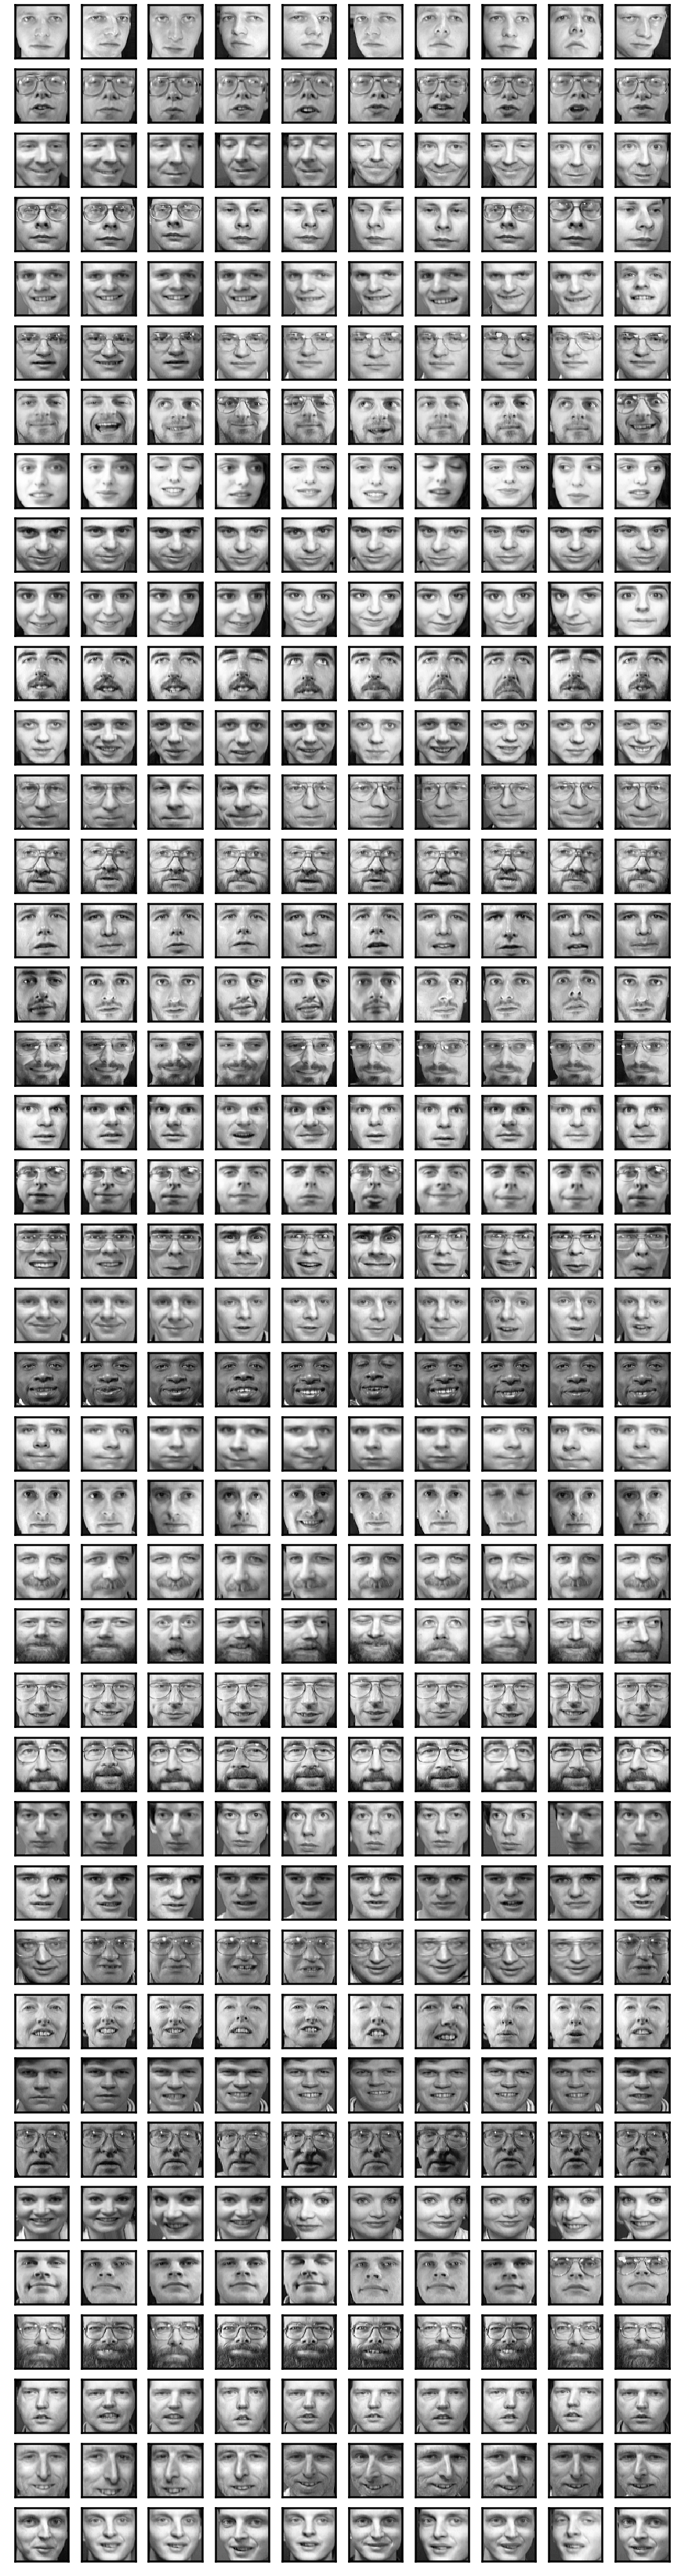

In [172]:
rows = 40
cols = 10

fig, ax = plt.subplots(rows, cols, figsize = (15, 1.5*rows))
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(faces.images[i*10 + j], cmap='gray')
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)

In [174]:
fig.savefig('all_faces.png')

**Using our algorithm to cluster**

In [202]:
%%time
pref = -210 # this gives us exactly 40 classes
exemplars,labels,Cluster_Centers,last_iteration=affinity_propagation(faces.data,preference=pref,max_iter=200,Plot_Clusters=False)
print("Number of exemplars: %i" % len(exemplars))


[ 17  59  60  62  74  79  83 105 114 118 139 149 151 165 177 182 187 206
 218 236 238 245 250 262 274 275 291 302 308 319 322 335 345 351 360 363
 376 380 391 396] 63
Number of exemplars: 40
CPU times: user 464 ms, sys: 548 ms, total: 1.01 s
Wall time: 391 ms


In [228]:
exemplars

array([ 17,  59,  60,  62,  74,  79,  83, 105, 114, 118, 139, 149, 151,
       165, 177, 182, 187, 206, 218, 236, 238, 245, 250, 262, 274, 275,
       291, 302, 308, 319, 322, 335, 345, 351, 360, 363, 376, 380, 391,
       396])

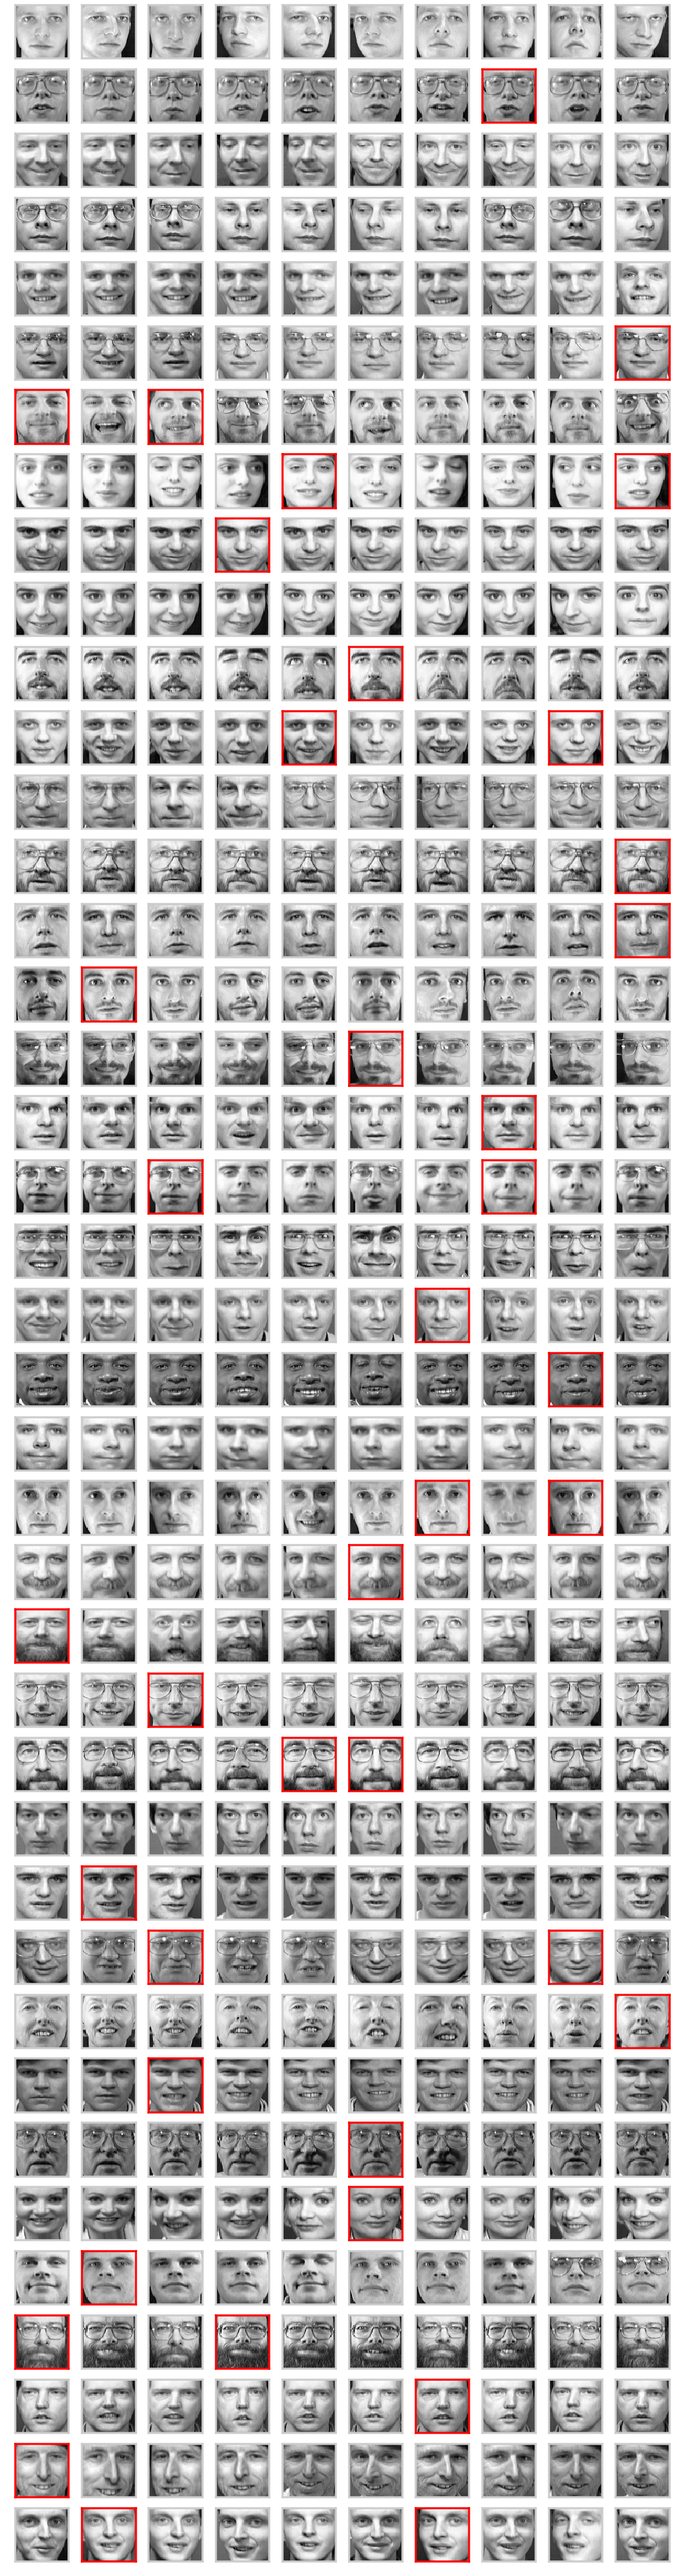

In [243]:
# Plot faces with exemplars highlighted
rows = 40
cols = 10

fig, ax = plt.subplots(rows, cols, figsize = (15, 1.5*rows))
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(faces.images[i*10 + j], cmap='gray')
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)
        if i*10+j in exemplars:
            for spine in ax[i,j].spines.values():
                spine.set_edgecolor('red')

In [244]:
fig.savefig('faces_exemplars_AP.png')

In [226]:
# Match accuracy

# array of image features (4096 pixels each) with true label
faces_targets = np.c_[faces.data, faces.target]

# add a column of the class of the exemplar each face is assigned to
exemplar_class = faces_targets[labels, 4096]
faces_targets = np.c_[faces_targets, exemplar_class]

# See how many of these is a correct match (i.e. true label vs. exemplar label)
true_label = faces_targets[:,4096]
exemplar_label = faces_targets[:,4097]
np.sum(true_label == exemplar_label)/len(faces.data)

0.575

In [270]:
# Mean square error

sim = []

# for each image
for i in range(400):
    # exemplar image
    exemplar_image = labels[i]
    # exemplar image data
    exemplar_data = faces.data[exemplar_image]
    image_data = faces.data[i]
    # calculate squared error
    error = Similarity(image_data, exemplar_data)
    sim.append(error)

np.mean(sim)

-51.113216

**Using K-Means**

In [304]:
km_labels = np.zeros((100,40))
km_labels[0,:] = np.arange(40)
km_labels

array([[ 0.,  1.,  2., ..., 37., 38., 39.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [312]:
%%time
n_clusters = 40
runs = 100

args = ()
kwds = {'n_clusters' : n_clusters}

km_labels, km_cluster_centers = Sklearn_clusters(faces.data, cluster.KMeans, args, kwds, Plot_Clusters=False)

Clustering took 7.68 s
CPU times: user 16.6 s, sys: 27 s, total: 43.6 s
Wall time: 7.68 s


In [313]:
# running KMeans 100 times
n_clusters = 40
runs = 100

args = ()
kwds = {'n_clusters' : n_clusters}

km_labels_list = []
km_cluster_centers_list = []
for i in range(runs):
    km_labels, km_cluster_centers = Sklearn_clusters(faces.data, cluster.KMeans, args, kwds, Plot_Clusters=False)
    km_labels_list.append(km_labels)
    km_cluster_centers_list.append(km_cluster_centers_list)

Clustering took 6.80 s
Clustering took 7.04 s
Clustering took 6.23 s
Clustering took 5.87 s
Clustering took 6.12 s
Clustering took 5.92 s
Clustering took 6.92 s
Clustering took 7.96 s
Clustering took 6.69 s
Clustering took 7.30 s
Clustering took 7.92 s
Clustering took 7.12 s
Clustering took 7.20 s
Clustering took 5.71 s
Clustering took 6.96 s
Clustering took 7.70 s
Clustering took 7.50 s
Clustering took 6.56 s
Clustering took 7.38 s
Clustering took 6.41 s
Clustering took 6.81 s
Clustering took 6.52 s
Clustering took 5.94 s
Clustering took 7.19 s
Clustering took 6.78 s
Clustering took 6.20 s
Clustering took 6.81 s
Clustering took 7.22 s
Clustering took 6.16 s
Clustering took 7.02 s
Clustering took 7.51 s
Clustering took 7.52 s
Clustering took 7.36 s
Clustering took 7.75 s
Clustering took 7.50 s
Clustering took 8.05 s
Clustering took 7.39 s
Clustering took 6.26 s
Clustering took 7.67 s
Clustering took 6.19 s
Clustering took 6.82 s
Clustering took 6.39 s
Clustering took 6.37 s
Clustering 

In [315]:
# Mean square error
km_sim = np.arange(runs, dtype=float)

# for each run
for run in range(runs):
    temp = []
    # for each image
    for i in range(400):
        # cluster center assigned to image i
        cluster_center = km_labels_list[run][i]
        # cluster center image data
        cluster_center_data = faces.data[cluster_center]
        image_data = faces.data[i]
        # calculate squared error
        error = Similarity(image_data, cluster_center_data)
        temp.append(error)
    km_sim[run] = np.mean(temp)

km_sim

array([-154.51976013, -145.06756592, -152.48471069, -149.46337891,
       -157.8319397 , -153.0067749 , -163.58052063, -156.82196045,
       -155.51731873, -151.71206665, -139.33087158, -160.78253174,
       -149.80596924, -152.39111328, -165.47831726, -154.39082336,
       -140.595047  , -153.56781006, -153.13165283, -155.68365479,
       -169.28755188, -154.01324463, -151.50326538, -145.40484619,
       -151.57781982, -154.74865723, -156.78552246, -146.13661194,
       -148.88946533, -158.02313232, -162.30731201, -144.04298401,
       -148.42086792, -145.30316162, -154.02984619, -151.92752075,
       -168.76828003, -147.43217468, -151.18347168, -150.96893311,
       -150.22314453, -152.60968018, -154.04194641, -150.39842224,
       -147.38562012, -148.12506104, -160.60263062, -147.70053101,
       -151.57531738, -156.5977478 , -154.96746826, -156.09327698,
       -142.17779541, -153.87077332, -151.50956726, -152.13130188,
       -160.97224426, -142.02586365, -154.83297729, -149.04814

In [317]:
# the best run of KMeans and avg. MSE of KMeans
np.max(km_sim), np.mean(km_sim)

(-139.33087158203125, -153.3774690246582)

In [286]:
# Comparing KMeans with AP

# 15 images withthe worst square error from cluster center/exemplar under either method
AP_min_idx = np.argsort(sim)[:15]
KM_min_idx = np.argsort(km_sim)[:15]

AP_min_idx, KM_min_idx

(array([ 79, 354, 350,  59, 325,  78, 363, 360, 150, 302, 340, 316,  93,
        182,  62]),
 array([381, 386,  73, 384, 388, 281, 387, 385,  81, 389, 383, 113, 380,
         82, 289]))

### DNA

### Text of Frey and Dueck (2007)
Following the Supporting Online Material, page 5-6.

"For each sentence in the main text of this manuscript, words delimited by spaces were extracted, punctuation was removed, and words with fewer than 5 characters were discarded. The similarity of sentence i to sentence k was set to the negative sum of the information-theoretic costs (S5) of encoding every word in sentence i using the words in sentence k and a dictionary of all words in the manuscript. For each word in sentence i, if the word matched a word in sentence k, the coding cost for the word was set to the negative logarithm of the number of words in sentence k (the cost of coding the index of the matched word), and otherwise it was set to the negative logarithm of the number of words in the manuscript dictionary (the cost of coding the index of the word in the manuscript dictionary). A word was considered to match another word if either word was a substring of the other."


**Importing sentences**

In [341]:
with open('paper.txt') as file:
    text = file.read()

In [664]:
import re
sentences = [(i, sentence) for i,sentence in enumerate(re.split('\. |\n', text))]
sentences

[(0,
  'Clustering data by identifying a subset of representative examples is important for processing sensory signals and detecting patterns in data'),
 (1,
  'Such "exemplars" can be found by randomly choosing an initial subset of data points and then iteratively refining it, but this works well only if that initial choice is close to a good solution'),
 (2,
  'We devised a method called "affinity propagation," which takes as input measures of similarity between pairs of data points'),
 (3,
  'Real-valued messages are exchanged between data points until a high-quality set of exemplars and corresponding clusters gradually emerges'),
 (4,
  'We used affinity propagation to cluster images of faces, detect genes in microarray data, identify representative sentences in this manuscript, and identify cities that are efficiently accessed by airline travel'),
 (5,
  'Affinity propagation found clusters with much lower error than other methods, and it did so in less than one-hundredth the amou

In [665]:
sentences_key = dict(sentences)

In [666]:
sentences_stripped = [(i," ".join(sentence.split()).translate(str.maketrans("","",string.punctuation)).lower()) 
                      for i,sentence in enumerate(re.split('\. |\n', text))]
sentences_stripped


[(0,
  'clustering data by identifying a subset of representative examples is important for processing sensory signals and detecting patterns in data'),
 (1,
  'such exemplars can be found by randomly choosing an initial subset of data points and then iteratively refining it but this works well only if that initial choice is close to a good solution'),
 (2,
  'we devised a method called affinity propagation which takes as input measures of similarity between pairs of data points'),
 (3,
  'realvalued messages are exchanged between data points until a highquality set of exemplars and corresponding clusters gradually emerges'),
 (4,
  'we used affinity propagation to cluster images of faces detect genes in microarray data identify representative sentences in this manuscript and identify cities that are efficiently accessed by airline travel'),
 (5,
  'affinity propagation found clusters with much lower error than other methods and it did so in less than onehundredth the amount of time'),

In [667]:
sentences_final = [(index, " ".join(list_of_words))
                   for (index, list_of_words) in [(index, [word for word in sentence_words if len(word) >= 5]) 
                                         for index,sentence_words in [(index,sentence.split()) 
                                                                      for index,sentence in sentences_stripped]] 
                   if len(list_of_words) > 0]
sentences_final

[(0,
  'clustering identifying subset representative examples important processing sensory signals detecting patterns'),
 (1,
  'exemplars found randomly choosing initial subset points iteratively refining works initial choice close solution'),
 (2,
  'devised method called affinity propagation which takes input measures similarity between pairs points'),
 (3,
  'realvalued messages exchanged between points until highquality exemplars corresponding clusters gradually emerges'),
 (4,
  'affinity propagation cluster images faces detect genes microarray identify representative sentences manuscript identify cities efficiently accessed airline travel'),
 (5,
  'affinity propagation found clusters lower error other methods onehundredth amount'),
 (7,
  'clustering based measure similarity critical scientific analysis engineering systems'),
 (8,
  'common approach learn centers squared errors between points their nearest centers small'),
 (9,
  'centers selected actual points called exemplars

In [668]:
len(sentences_final)

124

In [669]:
sentences_final_data = [sentences for i,sentences in sentences_final]

**Full dictionary**

In [671]:
dictionary = set([word for words in [sentence.split() for i,sentence in sentences_final] for word in words])

In [672]:
len(dictionary)

620

**Similarity of sentences (using for loops)**

In [673]:
def sentence_similarity(i, k, dictionary):
    '''Returns similarity of sentence i and sentence k, given full dictionary 
    
    From Frey and Dueck (2007):
    
    The similarity of sentence i to sentence k was set to the negative sum of the 
    information-theoretic costs (S5) of encoding every word in sentence i using 
    the words in sentence k and a dictionary of all words in the manuscript. For 
    each word in sentence i, if the word matched a word in sentence k, the coding 
    cost for the word was set to the negative logarithm of the number of words in 
    sentence k (the cost of coding the index of the matched word), and otherwise it 
    was set to the negative logarithm of the number of words in the manuscript 
    dictionary (the cost of coding the index of the word in the manuscript dictionary). 
    A word was considered to match another word if either word was a substring of the other.
    '''
    
    # go through each word in sentence i
    
    sentence_i = i.split()
    sentence_k = k.split()
    
    # return 0 if sentences are the same
    if sentence_i == sentence_k:
        return 0
    
    sum = 0
    for word_i in sentence_i:
        counter = 0
        for word_k in sentence_k:
            counter += 1
            if (word_i in word_k) | (word_k in word_i):
                sum -= np.log(len(sentence_k))
                break
            elif counter < len(sentence_k):
                continue
            else: 
                sum -= np.log(len(dictionary))
                break
                
    return sum

In [674]:
i = sentences_final_data[0]
k = sentences_final_data[1]
i, k

('clustering identifying subset representative examples important processing sensory signals detecting patterns',
 'exemplars found randomly choosing initial subset points iteratively refining works initial choice close solution')

In [675]:
sentence_similarity(i, k, dictionary)

-66.93625211000665

In [676]:
# Check the answer. There's only one match ('subset') and sentence i has 11 words:
np.allclose(sentence_similarity(i, k, dictionary) ,
            -10*np.log(len(dictionary)) - np.log(len(k.split())))

True

Notice that `sentence_similarity` is not symmetric. Further, in our implementation, we automatically set sentence similarity to be 0 if the sentences are the same.

In [677]:
sentence_similarity(k, i, dictionary)

-85.98424848730716

In [678]:
sentence_similarity(i, i, dictionary)

0

**Similarity of sentences (using broadcasting)**

In [679]:
def sentence_similarity_efficient(list_of_sentences, dictionary):
    '''Returns similarity matrix of all sentences in list_of_sentences, given full dictionary, efficiently.
    
    From Frey and Dueck (2007):
    
    The similarity of sentence i to sentence k was set to the negative sum of the 
    information-theoretic costs (S5) of encoding every word in sentence i using 
    the words in sentence k and a dictionary of all words in the manuscript. For 
    each word in sentence i, if the word matched a word in sentence k, the coding 
    cost for the word was set to the negative logarithm of the number of words in 
    sentence k (the cost of coding the index of the matched word), and otherwise it 
    was set to the negative logarithm of the number of words in the manuscript 
    dictionary (the cost of coding the index of the word in the manuscript dictionary). 
    A word was considered to match another word if either word was a substring of the other.
    '''
    
    pass

**Apply affinity propagation to the document**

In [680]:
# Setting the preference
# Preference was set to the number of words in the sentence times the negative logarithm of the 
# number of words in the manuscript dictionary, plus some constant (set to 90 in the paper)
constant = -80
pref = [len(sentence.split())*(-np.log(len(dictionary))) + constant for sentence in sentences_final_data]

In [681]:
%%time
s_exemplars,s_labels,s_Cluster_Centers,s_last_iteration=affinity_propagation(sentences_final_data, 
                                                                             Similarity_metric_="Sentences",
                                                                             preference=pref, 
                                                                             max_iter=200, 
                                                                             Plot_Clusters=False)
print("Number of exemplars: %i" % len(s_exemplars))


[15 22 38 59] 38
Number of exemplars: 4
CPU times: user 916 ms, sys: 0 ns, total: 916 ms
Wall time: 920 ms


In [682]:
[sentences_final[i] for i in s_exemplars]

[(17,
  'affinity propagation takes input collection realvalued similarities between points where similarity indicates point index suited exemplar point'),
 (25,
  'priori points equally suitable exemplars preferences should common value value varied produce different numbers clusters'),
 (46,
  'availability selfresponsibility positive responsibilities candidate exemplar receives other points'),
 (70,
  'affinity propagation found exemplars lower squared error kcenters clustering')]

In [683]:
# Converting to full sentences
[sentences_key[key] for key in [i for i, sentence in [sentences_final[i] for i in s_exemplars]]]

['Affinity propagation takes as input a collection of real-valued similarities between data points, where the similarity s(i,k) indicates how well the data point with index k is suited to be the exemplar for data point i',
 'If a priori, all data points are equally suitable as exemplars, the preferences should be set to a common value- this value can be varied to produce different numbers of clusters',
 'The availability a(i,k) is set to the self-responsibility r(k,k) plus the sum of the positive responsibilities candidate exemplar k receives from other points',
 'Affinity propagation found exemplars with much lower squared error than the best of 100 runs of k-centers clustering (Fig']

**Apply K-Means clustering**

### Air travel

## Testing on other real-world examples

### Text of this paper